In [ ]:
# import packages
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import v2, Lambda, ToTensor
import matplotlib.pyplot as plt


In [ ]:
# import and download data
# transforms images from PIL image formate to normalized tensors - scales image's pixel intensity value from [0,1]
# transforms integer labels to one-hot encoded tensors
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=v2.Compose([
        #v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True)
    ]),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)


test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

In [ ]:
# descriptive statistics
labels = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

# find number of samples from each class (6k each)
[out_labels, inverse_indices, counts] = torch.unique(training_data.targets, sorted=True, return_counts=True, return_inverse=True)

<function matplotlib.pyplot.show(close=None, block=None)>

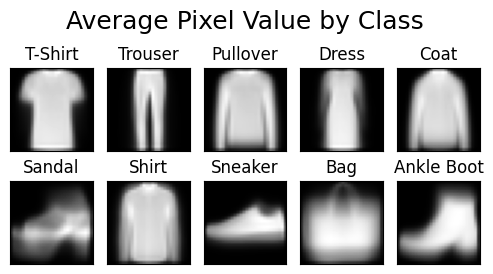

In [ ]:
# get average of all pixels for each clothing type

# define figure/subplots
plt.figure(figsize=(5, 3))
#plt.subplots_adjust(hspace=0.1, wspace = 0.1)

plt.suptitle("Average Pixel Value by Class", fontsize=18, y=0.95)

nonzeros_count_avg = np.empty(10, dtype = 'object')
zeros_count_avg = np.empty(10, dtype = 'object')
avg_img_value = np.empty(20, dtype = 'object')
img_means = np.empty(10, dtype = 'object')

for n, i_label in enumerate(labels):
  # create mask of T/F to get indices that match class i_label
  mask = inverse_indices == i_label
  # index training data given mask
  t_class = training_data.data[mask]

  # get average number of black and non-black pixels for each class
  nonzeros_count_avg[n] = torch.count_nonzero(training_data.transform(t_class))/6000
  zeros_count_avg[n] = 28*28-nonzeros_count_avg[n]
  avg_img_value[n] = torch.mean(training_data.transform(t_class))
  avg_img_value[n+10] = torch.std(training_data.transform(t_class))


  # set axes and plot info
  ax = plt.subplot(2,5, n+1)
  img_means[n] = torch.mean(training_data.transform(t_class), 0)
  ax.imshow(torch.mean(training_data.transform(t_class), 0), cmap = "gray")
  ax.set_title(labels[i_label])
  ax.set_xticks([])
  ax.set_yticks([])

plt.tight_layout(h_pad = 1, w_pad=1)
plt.show

Text(0.5, 1.0, 'Average number of Non-Black Pixels')

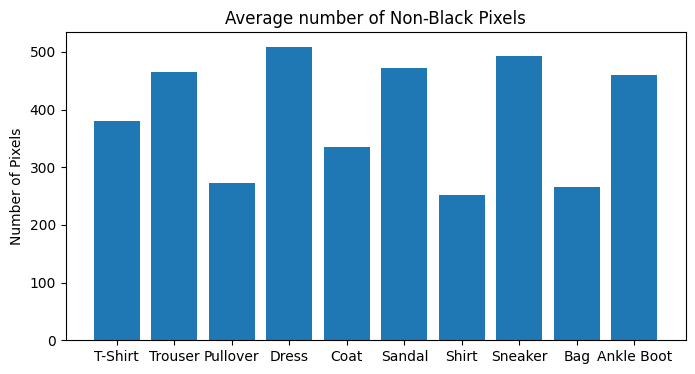

In [ ]:
plt.figure(figsize=(8, 4))
plt.bar(labels.values(),nonzeros_count_avg)
plt.ylabel('Number of Pixels')
plt.title('Average number of Non-Black Pixels')

Text(0.5, 1.0, 'Average pixel value for each class')

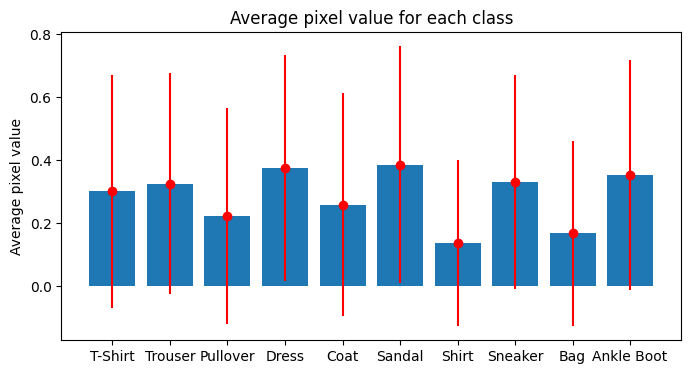

In [ ]:
plt.figure(figsize=(8, 4))
plt.bar(labels.values(),avg_img_value[0:10])
plt.errorbar(labels.values(),avg_img_value[0:10], yerr = avg_img_value[10:20], fmt='o', color='r')
plt.ylabel('Average pixel value')
plt.title('Average pixel value for each class')

<function matplotlib.pyplot.show(close=None, block=None)>

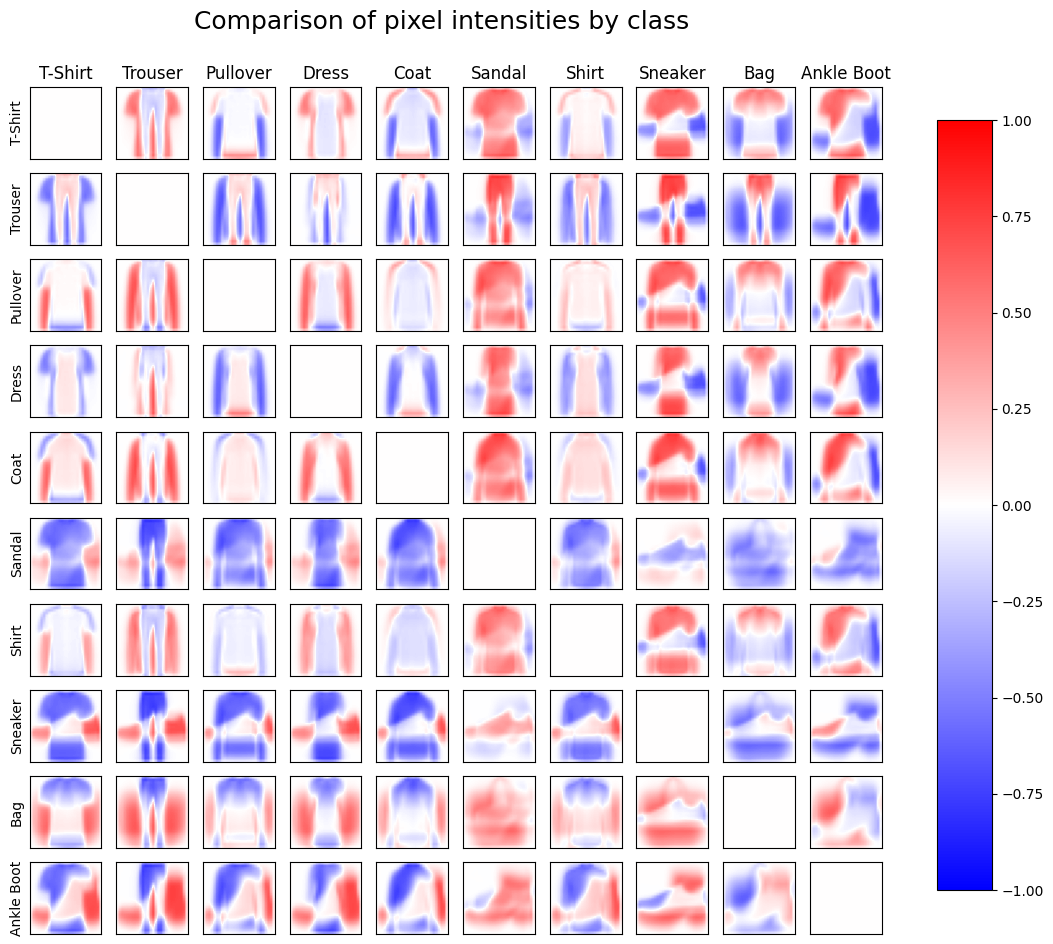

In [ ]:
# pairwise comparison of classes

# define figure/subplots
fig = plt.figure(figsize=(11, 11))
#fig.subplots_adjust(hspace=0, wspace = 0)
fig.tight_layout()
fig.suptitle("Comparison of pixel intensities by class", fontsize=18, y=0.95)
p = 1;
for j, avg_outer in enumerate(img_means):
  for k, avg_inner in enumerate(img_means):
    # find difference between average of 2 classes
    diff1 = avg_outer - avg_inner

    # set axes and plot info
    ax = plt.subplot(10,10, p)
    im = ax.imshow(diff1, cmap="bwr", vmin = -1, vmax = 1 )
    #ax.set_title(labels[i_label])
    ax.set_xticks([])
    ax.set_yticks([])

    if j == 0:
      ax.set_title(labels[k])
    if k == 0:
      ax.set_ylabel(labels[j])

    p = p + 1



fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show